In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
import random

In [2]:
def compute_chi(data):
    '''
    Computes the value of Chi, a synchrony measurement that compares the variance of individual voltage traces and the variance of the mean of the voltages.

    Parameters:
        data (list[float]):
            Voltage traces with each row corresponding one neuron.

    Returns:
        chi (float):
            The value of Chi.
    '''

    #calculate the average voltage as a function of time
    mean_voltage = np.mean(data,axis=0)

    #calculate the variance of each trave and the average voltage
    ind_variance = np.mean(np.square(data),axis=1) - np.mean(data,axis=1)**2
    total_variance = np.mean(np.square(mean_voltage)) - np.mean(mean_voltage)**2

    #calculate chi
    chi = np.sqrt(total_variance**2 / np.mean(ind_variance**2))

    return chi 


In [3]:
from scipy import signal
def compute_Reliability(spike_matrix,t,t_R):
    '''
    Computes the value of Reliability, a synchrony measurement that computes the variance of a convoluted spike train that is the sum of the spike trains of each neuron.

    Parameters:
        spike_matrix (tuple[tuple[int,int]] | sparse_matrix):
            matrix containing spike trains, each row contains a diffent neuron.
        t (list[float]):
            time array, time points of the simulation
        t_R (float):
            Time constant

    Returns:
        reliability / reliability_max (float):
            The computed value of reliability, normalised so (theorically) is between 0 and 1.
        Convolved_matrix (tuple[float]):
            The convolved spike train.
    '''

    #compute the time step of the simulation
    T = t[-1] - t[0]
    dt = T / len(t)

    #we need to work with a np.ndarray for the convolution, if it is a sparse_matrix, change it to that type
    if type(spike_matrix) is not np.ndarray:
        spike_matrix = np.array(spike_matrix.todense())

    #Compute the mean number of spikes
    num_spikes = (spike_matrix>0).sum()/num_neurons

    #Compute the kernel, and convolve the sum spike train with it
    joined_matrix = np.sum(spike_matrix,axis=0)
    kernel = 1/ t_R *np.exp(-t / t_R)
    Convolved_matrix = signal.convolve(joined_matrix,kernel)[0:len(spike_matrix[0,:])]
    #Convolved_matrix = joined_matrix

    #compute the measurements of reliability
    reliability = 1 / t[len(t) - 1] * np.trapz(np.square(Convolved_matrix), dx = dt) - np.square( 1 / t[len(t) - 1] * np.trapz(Convolved_matrix,dx =dt))
    reliability_max = ( num_neurons**2 * num_spikes / ( t_R * 2 * T ) - ( num_neurons * num_spikes / T )**2 )
    #reliability_max = 1
    return reliability/reliability_max, Convolved_matrix

# Synaptic Dynamics (Fig. 3)

s(3.04) for the first system: 0.9999999999999994
s(3.04) for the second system: 1.0000235249246123


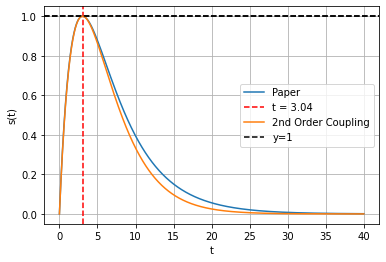

In [4]:
def dxdt(t, x, tau_r, tau_f):
    a = x[0]
    b = x[1]
    return [-a / tau_r, -b / tau_f]

t0 = 0
tfinal = 40
dt = 0.01
t = np.linspace(0, tfinal, 1000)

f = 3.0713828029683845  # Found to be correct value
x0 = [f, f]

sol1 = solve_ivp(dxdt, [t0, tfinal], x0, args=(2, 5), dense_output=True)

a = sol1.sol(t)[0]
b = sol1.sol(t)[1]

s1 = b - a

# Calculate s(4.03) for the first system
s1_at_4_03 = sol1.sol(3.043043043043043)[1] - sol1.sol(3.043043043043043)[0]
print(f"s(3.04) for the first system: {s1_at_4_03}")

# Plot for the first system
plt.plot(t, s1, label='Paper')
plt.ylabel('s(t)')
plt.xlabel('t')
plt.grid(True)
plt.axhline(1, color='k', linestyle='--')
plt.axvline(3.043043043043043, color='r', linestyle='--', label='t = 3.04')

# Second system
def dxdt_new(t, x, tau_s):
    s = x[0]
    p = x[1]
#     dsdt = -s / 2 + p / 2
#     dpdt = -p / 5
    dsdt = -s / 3.043043043043043 + p / 3.043043043043043
    dpdt = -p / 3.043043043043043
    return [dsdt, dpdt]

x0_new = [0, 2.7185823035951033]  # Obtained

sol2 = solve_ivp(dxdt_new, [t0, tfinal], x0_new, args=(5,), dense_output=True)

s2 = sol2.sol(t)[0]

# Calculate s(4.03) for the second system
s2_at_4_03 = sol2.sol(3.043043043043043)[0]
print(f"s(3.04) for the second system: {s2_at_4_03}")

# Plot for the second system
plt.plot(t, s2, label='2nd Order Coupling')
plt.axhline(1, color='k', linestyle='--', label='y=1')
plt.legend()
plt.show()


# Standard Neuron Simulation

# Sparsely Connected and Synchronous (Fig. 4 & 6)

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Average number of connections per neuron: 39.596666666666664
Connectivity Matrix g [[0.   0.03 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.03 0.   ... 0.   0.   0.03]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]]
Average value of matrix g= 0.003959666666666666
Chi measure (synchrony): 0.2665825157974826
Average firing rate 10.45
Reliability (normalized synchrony measure): 0.1103


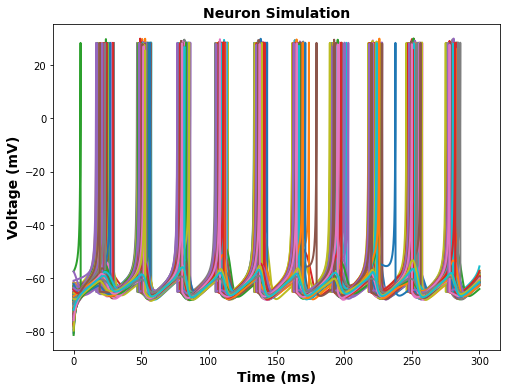

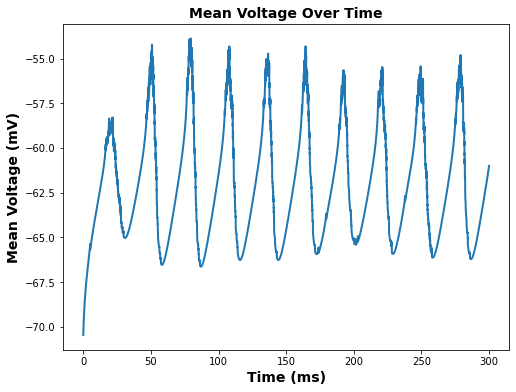

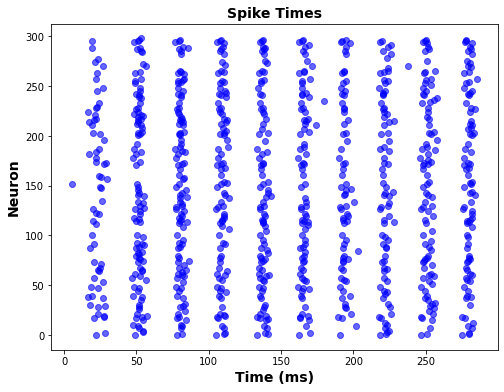

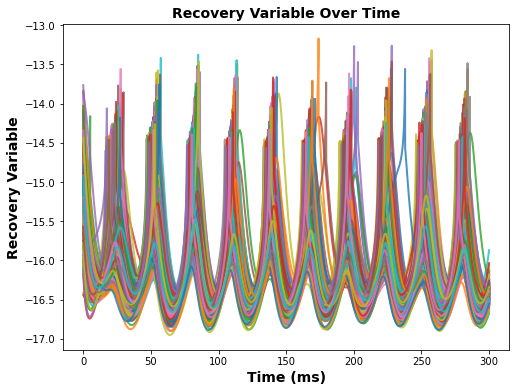

In [5]:
# Sparsely Connected
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('NeuronModel_Sparse.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('MeanVoltage_Sparse.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('SpikeTimes_Sparse.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('RecoveryVariable_Sparse.png')




# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

# Reliability calculation
num_neurons = N
t_R = 29.29/2 # Time constant for kernel, adjust as needed

# Construct time-aligned spike matrix
spike_matrix = np.zeros((num_neurons, len(t_all)))
for t_spike, neuron in spike_times:
    if t_spike > 0:
        idx = np.argmin(np.abs(t_all - t_spike))
        spike_matrix[int(neuron), idx] = 1

# Compute reliability
reliability_score, convolved_trace = compute_Reliability(spike_matrix, t_all, t_R)
print(f"Reliability (normalized synchrony measure): {reliability_score:.4f}")

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Neuron 0 spike times: [21.66023224477697, 48.911343111522044, 77.7315240711513, 105.33183972886036, 133.46847909629273, 162.56533674463677, 190.59514720141186, 218.69015982107703, 246.93582581644353, 275.4715722394342]
Neuron 1 spike times: [81.37433717539243, 110.27103114472754, 140.82195152104316, 222.54787864871815, 251.0498637919291, 279.8463029144284]
Neuron 2 spike times: [27.886905316326875, 110.927977495337, 138.99450590608265, 169.73722196981953, 279.7260375876486]
Neuron 3 spike times: [54.41399369210014, 223.51350659438586]
Neuron 4 spike times: [54.36804226414273, 224.3423059509395]
Neuron 5 spike times: []
Neuron 6 spike times: []
Neuron 7 spike times: [51.50799969745386, 80.65984198465122, 110.55281173338442, 139.9907440301066, 221.5715328098199, 253.12310992230707, 282.0568344806687]
Neuron 8 spike times: []
Neuron 9 spike times: [51.21442872158724, 81.55634310707195, 109.45257384485043, 138.1062976059275, 167.315427379281, 201.63279644751168, 279.45487139795694]
Neuron 

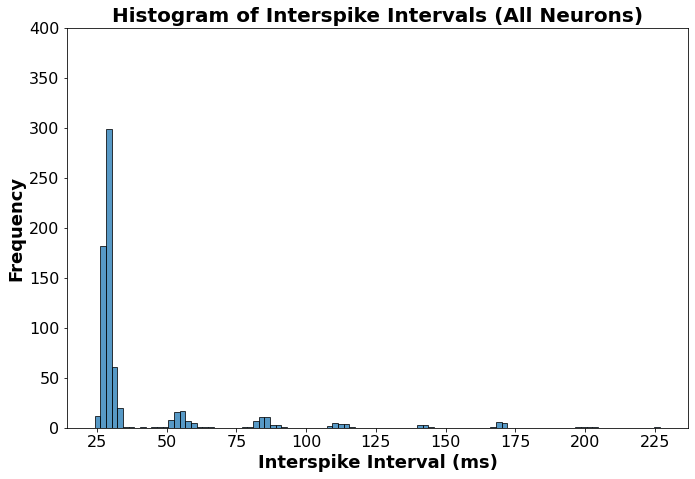

The most common interspike interval (ISI) is: 29.29 ms


In [6]:
# Initialize spike time dictionary
neuron_spike_times = {i: [] for i in range(N)}

# Record spike times per neuron
for time, neuron in spike_times:
    if neuron < N:
        neuron_spike_times[int(neuron)].append(time)

# Print spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")

# Count neurons that spiked vs. did not
num_spiked = sum(1 for times in neuron_spike_times.values() if times)
num_not_spiked = N - num_spiked

print(f"Number of neurons that spiked: {num_spiked}")
print(f"Number of neurons that did not spike: {num_not_spiked}")

# Compute ISIs for each neuron
interspike_intervals = {
    neuron: [times[i + 1] - times[i] for i in range(len(times) - 1)]
    for neuron, times in neuron_spike_times.items() if len(times) > 1
}

# Flatten ISIs from all neurons into one list
all_isis = [isi for neuron_isis in interspike_intervals.values() for isi in neuron_isis]

# Plot histogram of ISIs if data is available
if all_isis:
    plt.figure(figsize=(10, 7))
    frequencies, bin_edges, _ = plt.hist(all_isis, bins=100, alpha=0.75, edgecolor='k')

    plt.title("Histogram of Interspike Intervals (All Neurons)", fontsize=20, fontweight='bold')
    plt.xlabel("Interspike Interval (ms)", fontsize=18, fontweight='bold')
    plt.ylabel("Frequency", fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 400)
    plt.tight_layout()

    plt.savefig('Histogram_Interspike_Intervals_Sparse.png')
    plt.show()

    # Report the most common ISI
    max_freq_idx = np.argmax(frequencies)
    most_common_isi = (bin_edges[max_freq_idx] + bin_edges[max_freq_idx + 1]) / 2
    print(f"The most common interspike interval (ISI) is: {most_common_isi:.2f} ms")
else:
    print("No ISIs found across neurons to plot.")


# Sparsely Connected and Asynchronous (Fig. 4 & 6)

Average number of connections per neuron: 39.596666666666664
Connectivity Matrix g [[0.   0.03 0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.03 0.   ... 0.   0.   0.03]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.03 0.  ]]
Average value of matrix g= 0.003959666666666666
Chi measure (synchrony): 0.011658193345884868
Average firing rate 11.233333333333333
Reliability (normalized synchrony measure): 0.0075


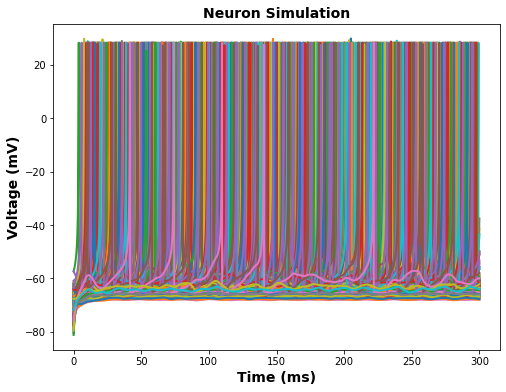

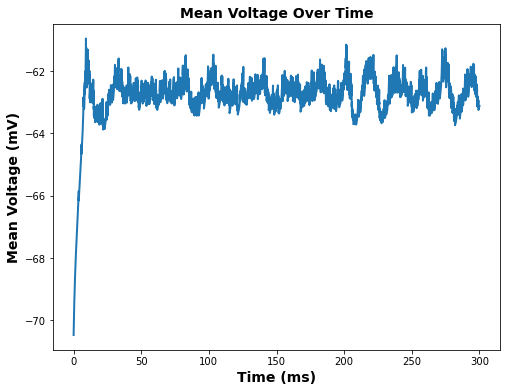

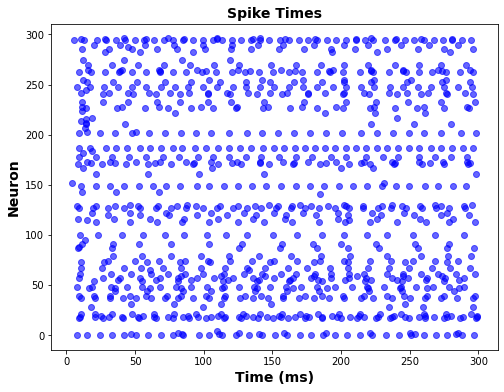

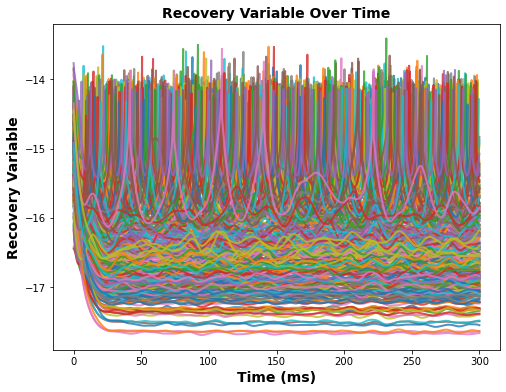

In [10]:
# Sparsely but completely asynchronous
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

#J = np.random.normal(0, 5, size=(N))

J = np.random.normal(0, 1, size=(N))
I = 0.33


# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# Sparsely connected networks with probabilistic connections
for j in range(N):
    for i in range(N):
        if i != j:  # Avoid self-connections
            if np.random.rand() < connection_probability:
                g[j, i] = 0.03  # Set connection strength 

# All-to-all connectivity
# g = np.random.uniform(0.05, 0.5, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections



v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('NeuronModel_Asynchronous.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('MeanVoltage_Asynchronous.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('SpikeTimes_Asynchronous.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('RecoveryVariable_Asynchronous.png')




# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

# Reliability calculation
num_neurons = N
t_R = 15.04/2 # Time constant for kernel, adjust as needed

# Construct time-aligned spike matrix
spike_matrix = np.zeros((num_neurons, len(t_all)))
for t_spike, neuron in spike_times:
    if t_spike > 0:
        idx = np.argmin(np.abs(t_all - t_spike))
        spike_matrix[int(neuron), idx] = 1

# Compute reliability
reliability_score, convolved_trace = compute_Reliability(spike_matrix, t_all, t_R)
print(f"Reliability (normalized synchrony measure): {reliability_score:.4f}")

Neuron 0 spike times: [7.749999243915961, 15.249427416109647, 24.38526785952855, 33.337122511043745, 42.13325920371189, 50.32695781093133, 59.205001877972606, 68.88632394975129, 77.43051456872536, 85.20324450212361, 96.21532128240057, 103.47018529749668, 113.46102268832348, 123.68172433024651, 132.73946615260323, 142.5931035958357, 151.9203567780686, 160.79529204430347, 169.90871200113583, 177.8500949826573, 186.76924324466992, 195.83170524319084, 204.1295398105728, 213.89458698687298, 222.7199581186271, 232.3921145098613, 242.00753268670243, 250.65453380803223, 260.0695207045462, 269.3062488738217, 277.45341104587345, 287.9376017029141, 296.68277122397166]
Neuron 1 spike times: [47.173012399282065, 83.95958569486315, 110.97042171760148, 140.4764414505836, 254.09277947522784, 283.5752491984948]
Neuron 2 spike times: [80.99090703608461, 125.5361422292655, 158.1972130073895, 189.3417411379707, 221.11331768634346, 249.90904106844707, 284.80287816000725]
Neuron 3 spike times: []
Neuron 4 s

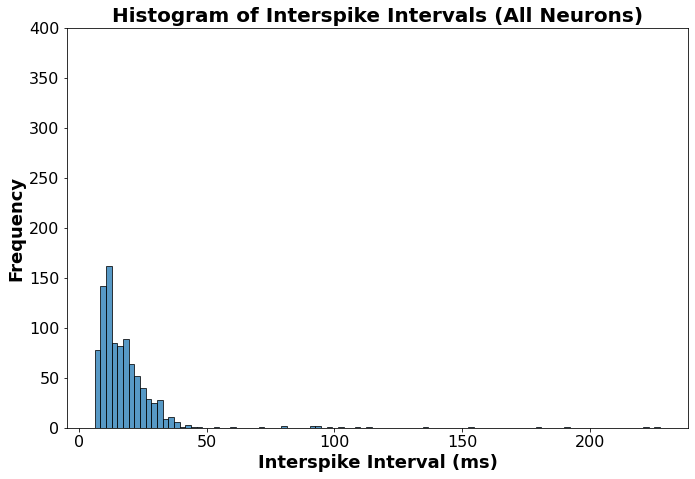

The most common interspike interval (ISI) is: 11.85 ms
The median interspike interval (ISI) is: 15.04 ms


In [8]:
neuron_spike_times = {i: [] for i in range(N)}

# Iterate through the spike_times array
for time, neuron in spike_times:
    if neuron < N:  # Ensure neuron index is within range 0-299
        neuron_spike_times[int(neuron)].append(time)

# Display spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")
# Count the number of neurons that spiked and did not spike
num_spiked = sum(bool(times) for times in neuron_spike_times.values())
num_not_spiked = N - num_spiked

# Display the counts
print(f"Number of neurons that spiked: {num_spiked}")
print(f"Number of neurons that did not spike: {num_not_spiked}")

# Calculate interspike intervals (ISIs) for each neuron
interspike_intervals = {neuron: [] for neuron in neuron_spike_times}

for neuron, times in neuron_spike_times.items():
    if len(times) > 1:  # Need at least two spikes to calculate ISI
        interspike_intervals[neuron] = [times[i + 1] - times[i] for i in range(len(times) - 1)]

# Flatten ISIs from all neurons
all_isis = [isi for neuron_isis in interspike_intervals.values() for isi in neuron_isis]

# Check if we have ISIs to process
if all_isis:
    plt.figure(figsize=(10, 7))
    frequencies, bin_edges, _ = plt.hist(all_isis, bins=100, alpha=0.75, edgecolor='k')

    plt.title("Histogram of Interspike Intervals (All Neurons)", fontsize=20, fontweight='bold')
    plt.xlabel("Interspike Interval (ms)", fontsize=18, fontweight='bold')
    plt.ylabel("Frequency", fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 400)
    plt.tight_layout()

    plt.savefig('Histogram_Interspike_Intervals_Asynchronous.png')
    plt.show()

    # Report the most common ISI
    max_freq_idx = np.argmax(frequencies)
    most_common_isi = (bin_edges[max_freq_idx] + bin_edges[max_freq_idx + 1]) / 2
    median_isi = np.median(all_isis)
    
    print(f"The most common interspike interval (ISI) is: {most_common_isi:.2f} ms")
    print(f"The median interspike interval (ISI) is: {median_isi:.2f} ms")
else:
    print("No ISIs found across neurons to plot.")

# All-to-all Connected and Synchronous (Fig. 5 & 6)

Average number of connections per neuron: 299.0
Connectivity Matrix g [[0.         0.00397291 0.00397291 ... 0.00397291 0.00397291 0.00397291]
 [0.00397291 0.         0.00397291 ... 0.00397291 0.00397291 0.00397291]
 [0.00397291 0.00397291 0.         ... 0.00397291 0.00397291 0.00397291]
 ...
 [0.00397291 0.00397291 0.00397291 ... 0.         0.00397291 0.00397291]
 [0.00397291 0.00397291 0.00397291 ... 0.00397291 0.         0.00397291]
 [0.00397291 0.00397291 0.00397291 ... 0.00397291 0.00397291 0.        ]]
Average value of matrix g= 0.003959666966666665
Chi measure (synchrony): 0.27154502211698406
Average firing rate 9.833333333333332
Reliability (normalized synchrony measure): 0.1033


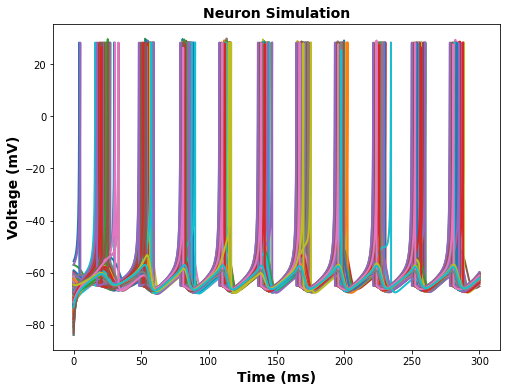

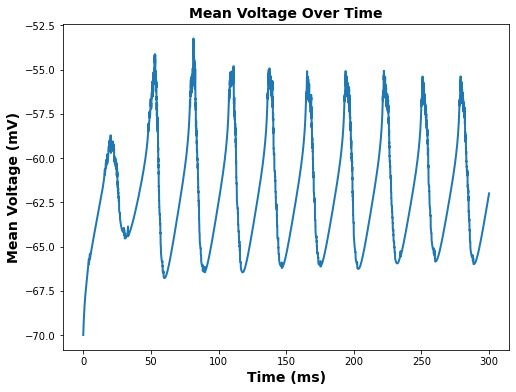

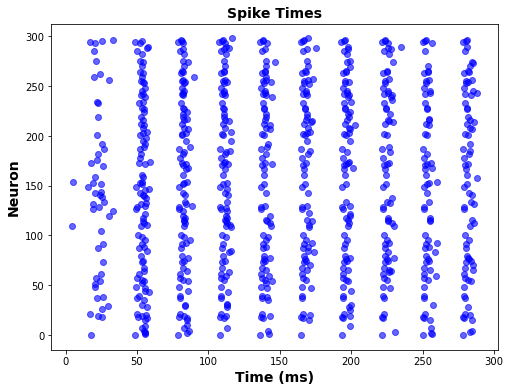

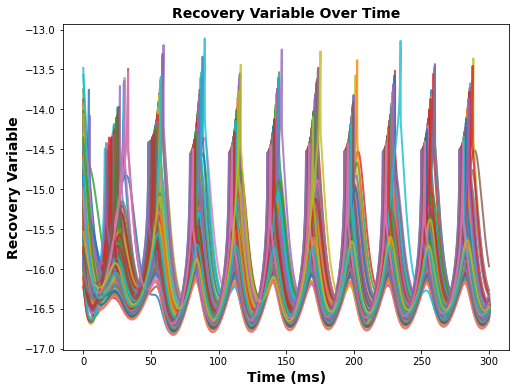

In [11]:
# A2A
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 0.1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# # Sparsely connected networks with probabilistic connections
# for j in range(N):
#     for i in range(N):
#         if i != j:  # Avoid self-connections
#             if np.random.rand() < connection_probability:
#                 g[j, i] = 0.03  # Set connection strength 

# # All-to-all connectivity
# g = np.random.uniform(0.003959666666666666, 0, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections

# Initialize the matrix with the desired value
g = np.full((N, N), 0.00397291)

# Set the diagonal elements to zero
np.fill_diagonal(g, 0)

v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('NeuronModel_A2A.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('MeanVoltage_A2A.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('SpikeTimes_A2A.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('RecoveryVariable_A2A.png')




# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

# Reliability calculation
num_neurons = N
t_R = 28.06/2  # Time constant for kernel, adjust as needed

# Construct time-aligned spike matrix
spike_matrix = np.zeros((num_neurons, len(t_all)))
for t_spike, neuron in spike_times:
    if t_spike > 0:
        idx = np.argmin(np.abs(t_all - t_spike))
        spike_matrix[int(neuron), idx] = 1

# Compute reliability
reliability_score, convolved_trace = compute_Reliability(spike_matrix, t_all, t_R)
print(f"Reliability (normalized synchrony measure): {reliability_score:.4f}")

Neuron 0 spike times: [17.717949513854666, 48.36315885145691, 78.99362845089871, 107.80779558106018, 136.35427642942116, 164.78205454578983, 193.25912541069587, 221.57574562504814, 250.11246833272003, 278.23957003800314]
Neuron 1 spike times: [55.422091242232135, 142.3545501606946, 256.4234504663619]
Neuron 2 spike times: [55.311411076710414, 85.20108606815066, 255.94438396843418]
Neuron 3 spike times: [55.83294023144094, 230.4864168658175, 282.9664493774193]
Neuron 4 spike times: [54.88344719871277, 86.05333972002798, 141.74324942125156, 284.68021942151506]
Neuron 5 spike times: []
Neuron 6 spike times: []
Neuron 7 spike times: [53.215972960313024, 83.22522898679627, 113.07166903033472, 255.73094504138862]
Neuron 8 spike times: []
Neuron 9 spike times: [55.90732513423898, 199.45759638222216]
Neuron 10 spike times: [84.81192523106778]
Neuron 11 spike times: []
Neuron 12 spike times: []
Neuron 13 spike times: []
Neuron 14 spike times: []
Neuron 15 spike times: [55.34726431966833, 84.975

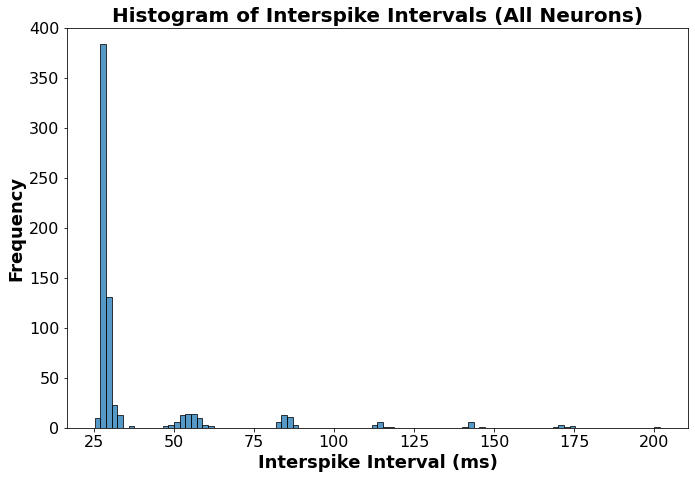

The most common interspike interval (ISI) is: 28.06 ms


In [12]:
neuron_spike_times = {i: [] for i in range(N)}

# Iterate through the spike_times array
for time, neuron in spike_times:
    if neuron < N:  # Ensure neuron index is within range 0-299
        neuron_spike_times[int(neuron)].append(time)

# Display spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")
# Count the number of neurons that spiked and did not spike
num_spiked = sum(bool(times) for times in neuron_spike_times.values())
num_not_spiked = N - num_spiked

# Display the counts
print(f"Number of neurons that spiked: {num_spiked}")
print(f"Number of neurons that did not spike: {num_not_spiked}")

# Calculate interspike intervals (ISIs) for each neuron
interspike_intervals = {neuron: [] for neuron in neuron_spike_times}

for neuron, times in neuron_spike_times.items():
    if len(times) > 1:  # Need at least two spikes to calculate ISI
        interspike_intervals[neuron] = [times[i + 1] - times[i] for i in range(len(times) - 1)]

# Flatten ISIs from all neurons
all_isis = [isi for neuron_isis in interspike_intervals.values() for isi in neuron_isis]

# Check if we have ISIs to process
if all_isis:
    # Plot the histogram and get bin edges and frequencies
    plt.figure(figsize=(10, 7))
    frequencies, bin_edges, _ = plt.hist(all_isis, bins=100, alpha=0.75, edgecolor='k')

    plt.title("Histogram of Interspike Intervals (All Neurons)", fontsize=20, fontweight='bold')
    plt.xlabel("Interspike Interval (ms)", fontsize=18, fontweight='bold')
    plt.ylabel("Frequency", fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 400)
    plt.tight_layout()

    plt.savefig('Histogram_Interspike_Intervals_A2A.png')
    plt.show()

    # Report the most common ISI
    max_freq_idx = np.argmax(frequencies)
    most_common_isi = (bin_edges[max_freq_idx] + bin_edges[max_freq_idx + 1]) / 2
    print(f"The most common interspike interval (ISI) is: {most_common_isi:.2f} ms")
else:
    print("No ISIs found across neurons to plot.")

In [13]:
g= 0.003959666666666666
# Define matrix size
N = 300  # Change this to your desired size

# Desired average value
target_mean = 0.003959666666666666

# Compute the value for non-diagonal elements to maintain the target mean
g_off_diagonal = (target_mean * N**2) / (N**2 - N)

# Initialize the matrix with the computed value
g = np.full((N, N), g_off_diagonal)

# Set the diagonal elements to zero
np.fill_diagonal(g, 0)

# Print matrix
print("Generated matrix:\n", g)

# Verify the mean value
actual_mean = np.mean(g)
print(f"Actual mean of the matrix: {actual_mean:.16f} (should be {target_mean})")


Generated matrix:
 [[0.         0.00397291 0.00397291 ... 0.00397291 0.00397291 0.00397291]
 [0.00397291 0.         0.00397291 ... 0.00397291 0.00397291 0.00397291]
 [0.00397291 0.00397291 0.         ... 0.00397291 0.00397291 0.00397291]
 ...
 [0.00397291 0.00397291 0.00397291 ... 0.         0.00397291 0.00397291]
 [0.00397291 0.00397291 0.00397291 ... 0.00397291 0.         0.00397291]
 [0.00397291 0.00397291 0.00397291 ... 0.00397291 0.00397291 0.        ]]
Actual mean of the matrix: 0.0039596666666667 (should be 0.003959666666666666)


# All-to-all Connected and Asynchronous (Fig. 5 & 6)

Average number of connections per neuron: 299.0
Connectivity Matrix g [[0.         0.00397291 0.00397291 ... 0.00397291 0.00397291 0.00397291]
 [0.00397291 0.         0.00397291 ... 0.00397291 0.00397291 0.00397291]
 [0.00397291 0.00397291 0.         ... 0.00397291 0.00397291 0.00397291]
 ...
 [0.00397291 0.00397291 0.00397291 ... 0.         0.00397291 0.00397291]
 [0.00397291 0.00397291 0.00397291 ... 0.00397291 0.         0.00397291]
 [0.00397291 0.00397291 0.00397291 ... 0.00397291 0.00397291 0.        ]]
Average value of matrix g= 0.003959666966666665
Chi measure (synchrony): 0.011147121155214362
Average firing rate 9.799999999999999
Reliability (normalized synchrony measure): 0.0061


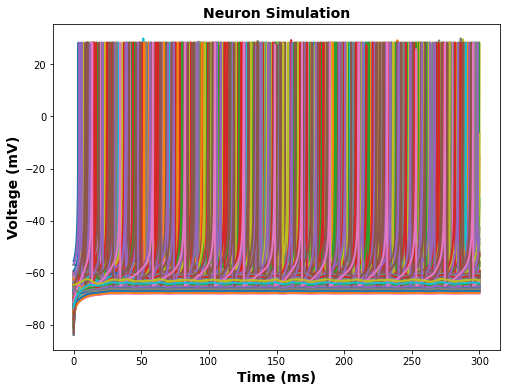

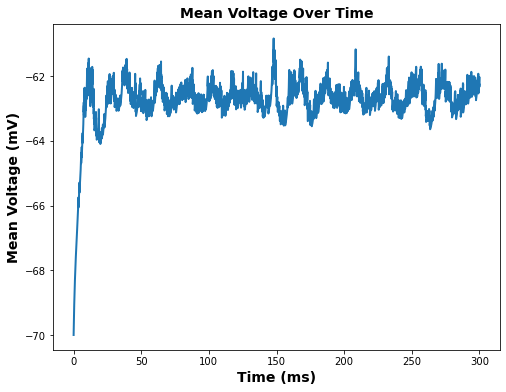

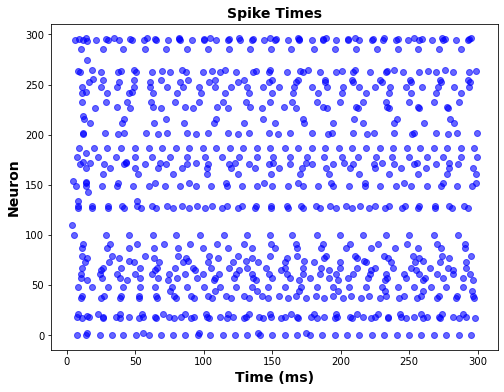

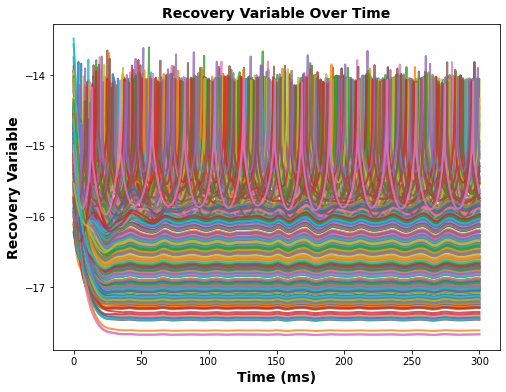

In [17]:
# A2A Asynchronous
np.random.seed(101)

N = 300
T = 300
M = 50000
dt = 0.005
t0 = 0

k = 1
a = 0.1
b = 0.26
c = -65
d = -1
v_reset = c
v_thresh = 30

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

J = np.random.normal(0, 1, size=(N))


I = 0.33

# Define desired average number of connections
Avg_Connections = 40
connection_probability = Avg_Connections / N

# Initialize the synaptic coupling matrix
g = np.zeros((N, N))

# # Sparsely connected networks with probabilistic connections
# for j in range(N):
#     for i in range(N):
#         if i != j:  # Avoid self-connections
#             if np.random.rand() < connection_probability:
#                 g[j, i] = 0.03  # Set connection strength 

# # All-to-all connectivity
# g = np.random.uniform(0.003959666666666666, 0, size=(N, N))
# np.fill_diagonal(g, 0)  # Set diagonal to zero to avoid self-connections

# Initialize the matrix with the desired value
g = np.full((N, N), 0.00397291)

# Set the diagonal elements to zero
np.fill_diagonal(g, 0)

v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 0.5, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = np.zeros(N)
p_init = np.zeros(N)

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, s_init, p_init])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

spike_times = np.zeros((M, 2))
spikeCounter = 0
i = 0

def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N:3*N]
    p = x[3*N:4*N]
    
    dvdt = k * (0.04 * v**2 + 5 * v + 140 - u + I) + J - (v - Esyn) * np.dot(g,s)
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, dsdt, dpdt])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, s_init, p_init])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t[:-1]], axis=0)
    y_all = np.concatenate([y_all, y[:, :-1]], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N:3*N, -1]
    p_init = y[3*N:4*N, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init[spike] += (2.7185823035951033) #x0 
        
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('NeuronModel_A2A_Asyn.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('MeanVoltage_A2A_Asyn.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('SpikeTimes_A2A_Asyn.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('RecoveryVariable_A2A_Asyn.png')




# Count the number of non-zero entries in each row
connections_per_neuron = np.count_nonzero(g, axis=1)

# Calculate the average number of connections per neuron
average_connections = np.mean(connections_per_neuron)

print(f"Average number of connections per neuron: {average_connections}")
print("Connectivity Matrix g", g)
print("Average value of matrix g=", np.mean(g))
# Extract the voltage traces (first N rows of y_all)
voltage_data = y_all[:N, :]  # Shape: (N, time_steps)

# Compute the Chi measure
chi_value = compute_chi(voltage_data)

# Print the Chi measure
print(f"Chi measure (synchrony): {chi_value}")


average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

# Reliability calculation
num_neurons = N
t_R = 14.29/2  # Time constant for kernel, adjust as needed

# Construct time-aligned spike matrix
spike_matrix = np.zeros((num_neurons, len(t_all)))
for t_spike, neuron in spike_times:
    if t_spike > 0:
        idx = np.argmin(np.abs(t_all - t_spike))
        spike_matrix[int(neuron), idx] = 1

# Compute reliability
reliability_score, convolved_trace = compute_Reliability(spike_matrix, t_all, t_R)
print(f"Reliability (normalized synchrony measure): {reliability_score:.4f}")

Neuron 0 spike times: [7.602964005574705, 14.408212302039269, 24.191810196997274, 32.77323271031884, 41.33141760178302, 50.707225629123386, 59.87558575821703, 68.69119987069776, 77.88157781525781, 86.72549097472178, 96.06182125483606, 104.77984632980007, 114.09431766851048, 122.96988453270556, 131.90639518464442, 141.1627060074499, 149.80416180307702, 159.42996155234138, 167.98982582161204, 177.6725658291732, 186.41824059039317, 195.622421974379, 204.7583886232242, 213.56971456539654, 222.76280548742568, 231.60876979074928, 240.9703889849092, 249.8296968540559, 258.6751602441923, 268.1825150956706, 276.7726282879529, 286.14948559289235, 294.87788212805805]
Neuron 1 spike times: []
Neuron 2 spike times: [14.454390066352401, 55.71968087893683, 96.49325363742544, 139.79887630073003, 174.85037457344868]
Neuron 3 spike times: []
Neuron 4 spike times: []
Neuron 5 spike times: []
Neuron 6 spike times: []
Neuron 7 spike times: []
Neuron 8 spike times: []
Neuron 9 spike times: []
Neuron 10 spik

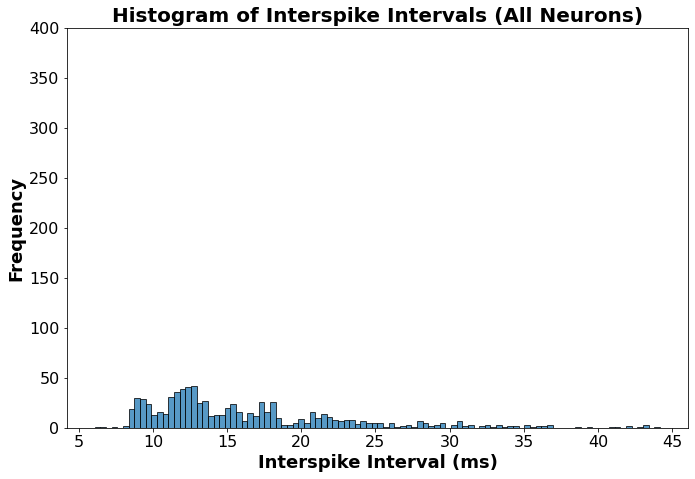

The most common interspike interval (ISI) is: 12.75 ms
The median interspike interval (ISI) is: 14.29 ms


In [16]:
neuron_spike_times = {i: [] for i in range(N)}

# Iterate through the spike_times array
for time, neuron in spike_times:
    if neuron < N:  # Ensure neuron index is within range 0-299
        neuron_spike_times[int(neuron)].append(time)

# Display spike times for each neuron
for neuron, times in neuron_spike_times.items():
    print(f"Neuron {neuron} spike times: {times}")
# Count the number of neurons that spiked and did not spike
num_spiked = sum(bool(times) for times in neuron_spike_times.values())
num_not_spiked = N - num_spiked

# Display the counts
print(f"Number of neurons that spiked: {num_spiked}")
print(f"Number of neurons that did not spike: {num_not_spiked}")

# Calculate interspike intervals (ISIs) for each neuron
interspike_intervals = {neuron: [] for neuron in neuron_spike_times}

for neuron, times in neuron_spike_times.items():
    if len(times) > 1:  # Need at least two spikes to calculate ISI
        interspike_intervals[neuron] = [times[i + 1] - times[i] for i in range(len(times) - 1)]

# Flatten ISIs from all neurons
all_isis = [isi for neuron_isis in interspike_intervals.values() for isi in neuron_isis]

# Check if we have ISIs to process
if all_isis:
    # Plot the histogram and get bin edges and frequencies
    # Plot the histogram and get bin edges and frequencies
    plt.figure(figsize=(10, 7))
    frequencies, bin_edges, _ = plt.hist(all_isis, bins=100, alpha=0.75, edgecolor='k')

    plt.title("Histogram of Interspike Intervals (All Neurons)", fontsize=20, fontweight='bold')
    plt.xlabel("Interspike Interval (ms)", fontsize=18, fontweight='bold')
    plt.ylabel("Frequency", fontsize=18, fontweight='bold')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 400)
    plt.tight_layout()

    plt.savefig('Histogram_Interspike_Intervals_A2A_Asyn.png')
    plt.show()

    # Report the most common ISI
    max_freq_idx = np.argmax(frequencies)
    most_common_isi = (bin_edges[max_freq_idx] + bin_edges[max_freq_idx + 1]) / 2
    median_isi = np.median(all_isis)
    print(f"The most common interspike interval (ISI) is: {most_common_isi:.2f} ms")
    print(f"The median interspike interval (ISI) is: {median_isi:.2f} ms")
else:
    print("No ISIs found across neurons to plot.")